# Luther - Linear Regression Model

This is where I work with the merged dataframe to fit a linear regression model in order to predict the opening box office gross

In [307]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings
warnings.filterwarnings('ignore')

In [290]:
# Import merged dataframe
merged2 = pd.read_pickle('merged2.pkl')
merged2.head(7)

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,year,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,2013,5649515.0,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,2013,4249150.0,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,2013,8467428.0,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,2013,454111.0,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,2013,382762.0,514.0,44.0,47.0,8.13,4458.3,81,843.5,10
5,Ender's Game,Ender's Game,27017351,3323167,2013-11-01,3407,61737191,6.9,6.7,51,...,2013,1673684.0,4379.0,288.0,1414.0,8.13,4902.1,52,0.0,0
6,Free Birds,Free Birds,15805237,1944063,2013-11-01,3736,55750480,6.9,5.9,38,...,2013,386277.0,945.0,77.0,130.0,8.13,2996.1,56,165.0,3


In [291]:
# add these columns to account for whether the actors/directors were identified
merged2["dirgross_bin"] = merged2.dir_gross.apply(lambda x: x/x if x > 0 else x)
merged2["actgross_bin"] = merged2.act_gross.apply(lambda x: x/x if x > 0 else x)
merged2.head()

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7,1.0,1.0
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3,1.0,1.0
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2,1.0,1.0
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9,1.0,1.0
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,514.0,44.0,47.0,8.13,4458.3,81,843.5,10,1.0,1.0


In [292]:
merged2.columns

Index(['movie_name', 'movie', 'op_gross', 'est_tick', 'date_time', 'theaters',
       'tot_gross', 'unemp_rate', 'imdb', 'metacritic', 'rated',
       'rotten_tomatoes', 'runtime', 'year', 'Yviews_adj', 'Ylikes_adj',
       'Ydis_adj', 'Ycom_adj', 'tick', 'act_gross', 'act_nmovies', 'dir_gross',
       'dir_nmovies', 'dirgross_bin', 'actgross_bin'],
      dtype='object')

In [293]:
#merged2.columns
#drop unnecessary/duplicate columns
merged2 = merged2.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)
merged2.head()

,est_tick,theaters,unemp_rate,imdb,metacritic,rated,rotten_tomatoes,runtime,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,19443331,4163,6.9,7.5,76,PG-13,89,146,5649515.0,23726.0,632.0,4329.0,3333.4,56,1056.5,7,1.0,1.0
1,29937,1,6.9,7.5,74,PG,90,102,4249150.0,6715.0,1074.0,925.0,1774.2,19,230.0,3,1.0,1.0
2,10545859,3841,6.9,7.0,54,PG-13,66,112,8467428.0,30885.0,1178.0,5576.0,2968.6,57,89.7,2,1.0,1.0
3,3703266,2024,6.9,6.7,59,R,70,123,454111.0,1194.0,72.0,172.0,1328.5,34,346.3,9,1.0,1.0
4,2009171,3065,6.9,6.6,48,PG-13,45,105,382762.0,514.0,44.0,47.0,4458.3,81,843.5,10,1.0,1.0


In [294]:
X = patsy.dmatrix('rated',data=merged2,return_type='dataframe')
X.head()

,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,1.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0


In [295]:
merged3 = merged2.join(X)
merged3 = merged3.drop(["rated"],1)
merged3.head()

,est_tick,theaters,unemp_rate,imdb,metacritic,rotten_tomatoes,runtime,Yviews_adj,Ylikes_adj,Ydis_adj,...,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,19443331,4163,6.9,7.5,76,89,146,5649515.0,23726.0,632.0,...,3333.4,56,1056.5,7,1.0,1.0,1.0,0.0,1.0,0.0
1,29937,1,6.9,7.5,74,90,102,4249150.0,6715.0,1074.0,...,1774.2,19,230.0,3,1.0,1.0,1.0,1.0,0.0,0.0
2,10545859,3841,6.9,7.0,54,66,112,8467428.0,30885.0,1178.0,...,2968.6,57,89.7,2,1.0,1.0,1.0,0.0,1.0,0.0
3,3703266,2024,6.9,6.7,59,70,123,454111.0,1194.0,72.0,...,1328.5,34,346.3,9,1.0,1.0,1.0,0.0,0.0,1.0
4,2009171,3065,6.9,6.6,48,45,105,382762.0,514.0,44.0,...,4458.3,81,843.5,10,1.0,1.0,1.0,0.0,1.0,0.0


In [296]:
#sns.pairplot(merged2)
#sns.regplot(merged2.unemp_rate, merged2.est_tick)
# Add 1 to the comments, director gross and actor gross in order to normalize data with 
# log or boxcox
merged3['Ycom_adj'] = merged3.Ycom_adj.apply(lambda x: x + 1)
merged3['dir_gross'] = merged3.dir_gross.apply(lambda x: x + 1)
merged3['act_gross'] = merged3.act_gross.apply(lambda x: x + 1)
merged3['act_nmovies'] = merged3.act_gross.apply(lambda x: x + 1)
merged3['dir_nmovies'] = merged3.act_gross.apply(lambda x: x + 1)

1.0050497830034506


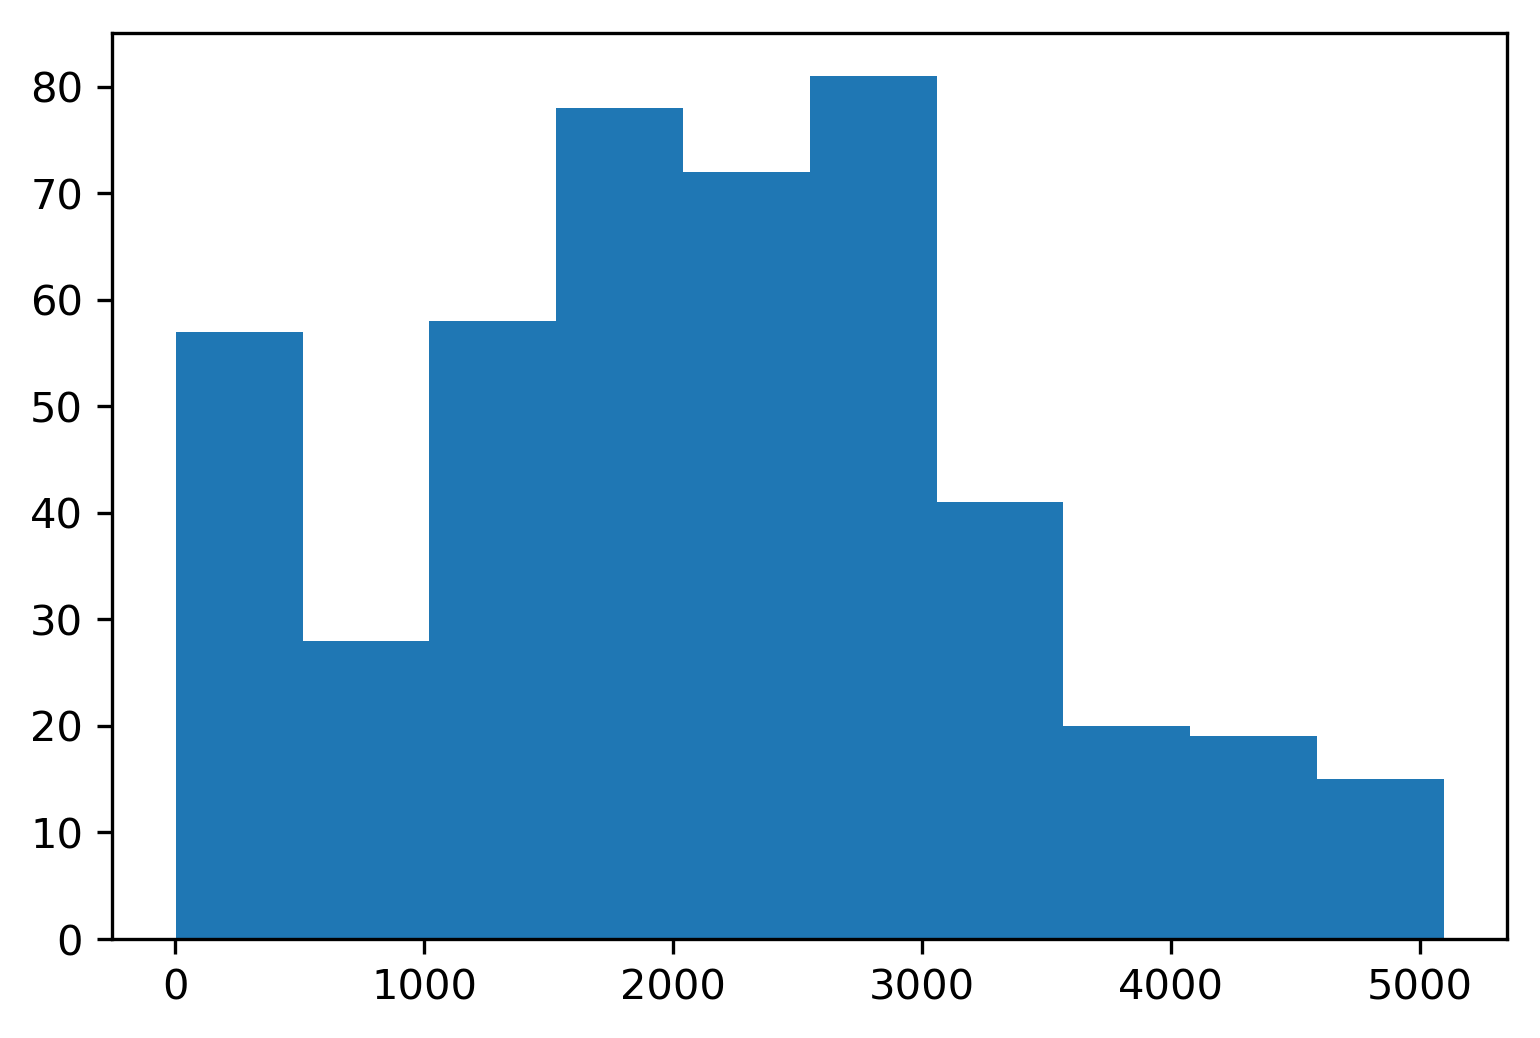

In [300]:
from scipy import stats

lamb=stats.boxcox_normmax(merged3.dir_nmovies, brack=(-1.9, 1.9))
print(lamb)
#dir_gross_box = (np.power(merged3.dir_gross,0.3458)-1)/0.3458
#y_t=(np.power(merged3.Ycom_adj,0.036781)-1)/0.036781

plt.hist(merged3.dir_nmovies);
#plt.hist(np.log(merged3.Ycom_adj))

In [273]:
# Normalize dataset
merged3["tick_log"] = np.log(merged3.est_tick)
merged3["Ylikes_log"] = np.log(merged3.Ylikes_adj)
merged3["Yviews_log"] = np.log(merged3.Yviews_adj)
merged3["Ydis_log"] = np.log(merged3.Ydis_adj)
merged3["runtime_log"] = np.log(merged3.runtime)
merged3["dir_gross"] = np.log(merged3.dir_gross)
merged3["act_gross"] = np.log(merged3.act_gross)
merged3["Ycom_log"] = np.log(merged3.Ycom_adj)
merged4 = merged3.drop(["est_tick","Ylikes_adj","Yviews_adj","Ydis_adj","runtime",
                       "act_gross","dir_gross","Ycom_adj"], 1)

In [301]:
#dir_nmovies
# act_nmovies
# sns.pairplot(merged4)

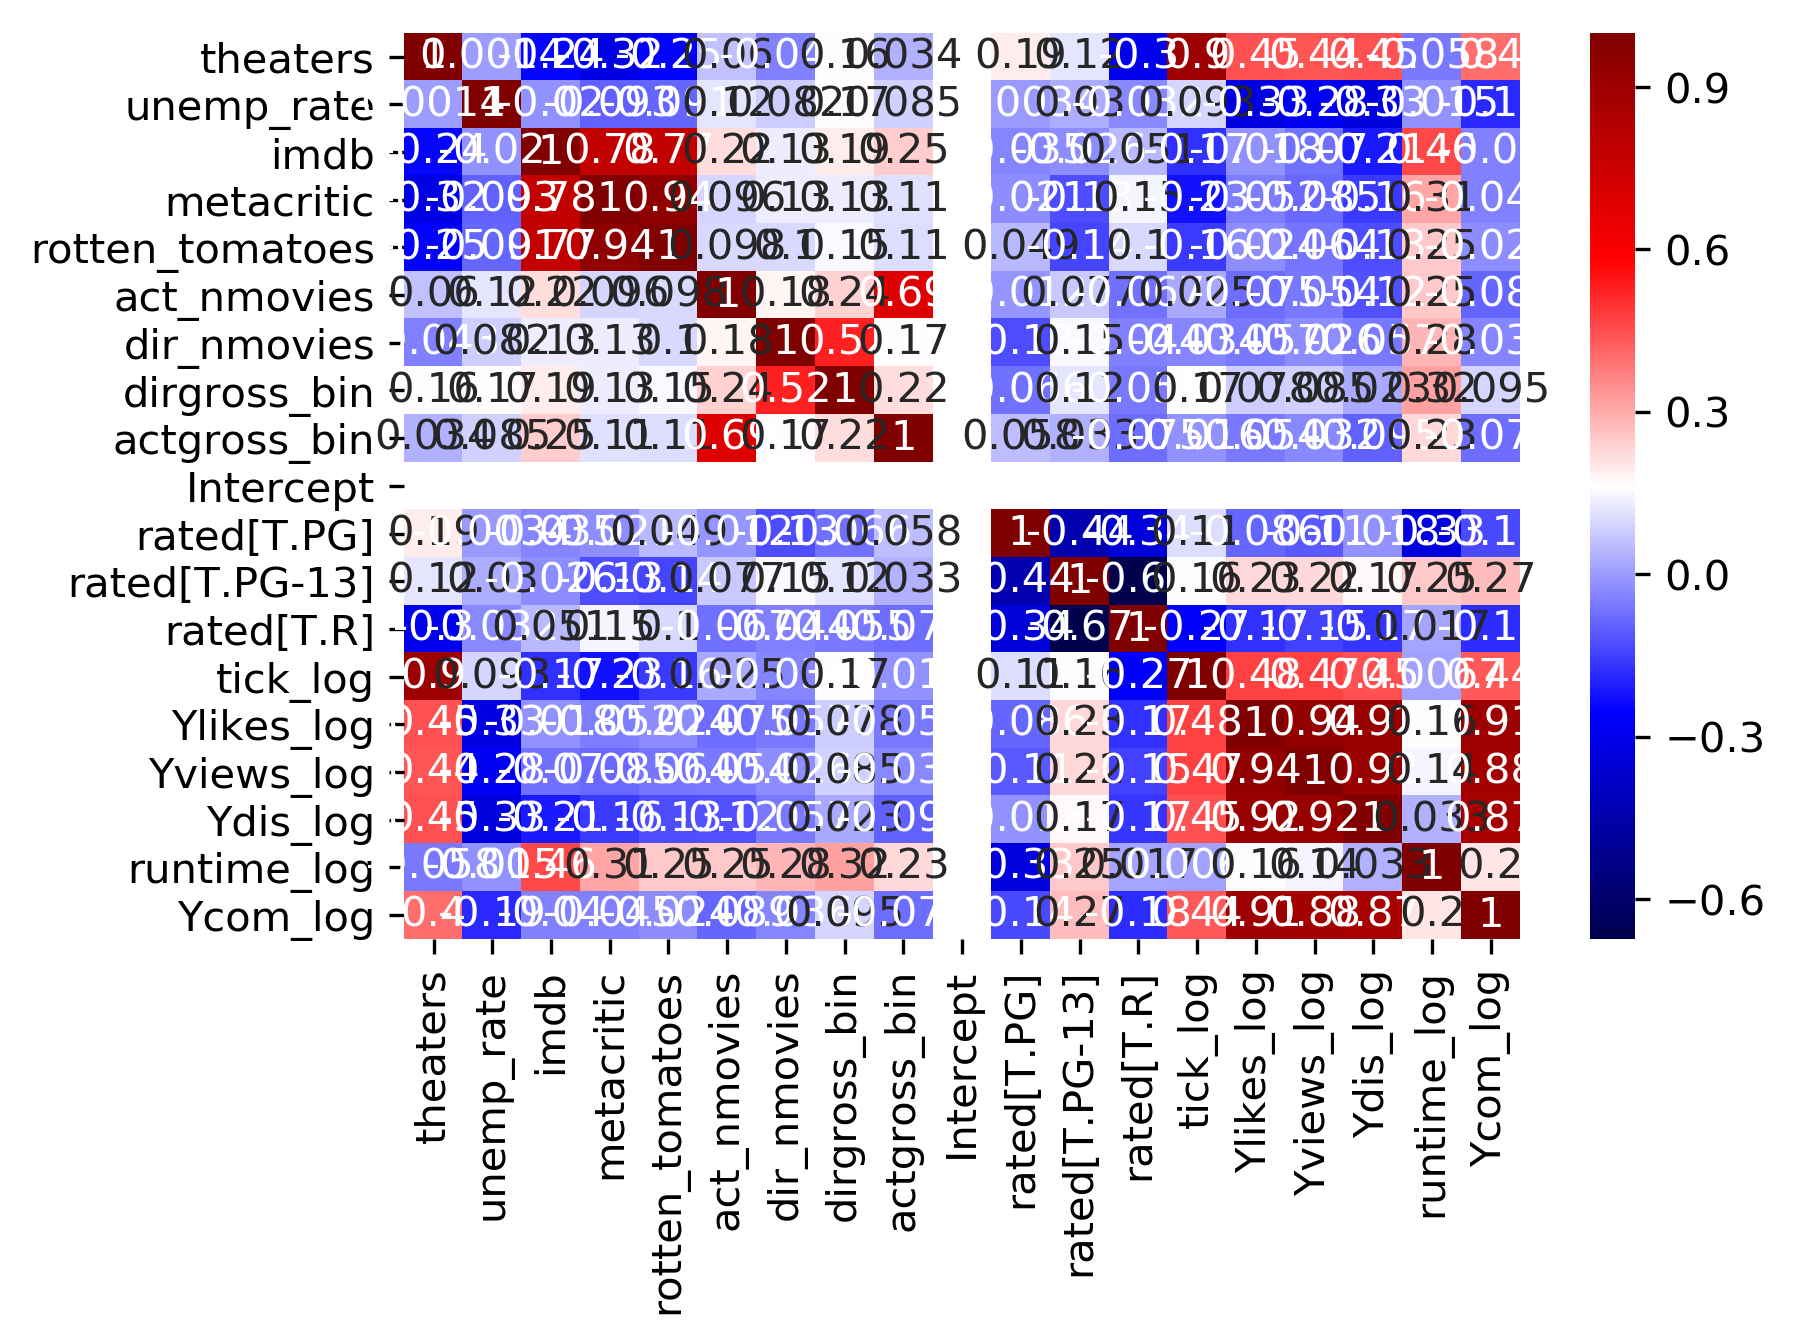

In [275]:
sns.heatmap(merged4.corr(), cmap = "seismic", annot=True)

In [303]:
merged4.columns

Index(['theaters', 'unemp_rate', 'imdb', 'metacritic', 'rotten_tomatoes',
       'act_nmovies', 'dir_nmovies', 'dirgross_bin', 'actgross_bin',
       'Intercept', 'rated[T.PG]', 'rated[T.PG-13]', 'rated[T.R]', 'tick_log',
       'Ylikes_log', 'Yviews_log', 'Ydis_log', 'runtime_log', 'Ycom_log'],
      dtype='object')

In [304]:
y = merged4.tick_log
X = merged4.drop(['tick_log'],1)

#model= LinearRegression()
#fit = model.fit(X,y)

In [305]:
# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
# The Xtrain and Ytrain will be used to train the data & cross validate
# X test and Y test will be used to assess the performance after CV

In [341]:
#Split CV
X_trainCV, X_CV, y_trainCV, y_CV = train_test_split(X_train,y_train,test_size = 0.3)

In [344]:
alphas = [0,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
elas_model = ElasticNetCV(alphas=alphas, l1_ratio=[1e-8, 1e-6, 1e-4, 1e-2, .5, 1])
fit = elas_model.fit(X_train,y_train)
#fit.predict(X_train)
fit.alpha_
fit.l1_ratio_

1e-08

In [360]:
# Linear model without polyfit
alphas = [0,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
l1 = [0, 1e-8, 1e-6, 1e-4, 1e-2, .5, .9, 1]
degree = 2
lin_model = make_pipeline(ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
lin_model.fit(X_trainCV,y_trainCV)
lin_model.score(X_CV,y_CV)

0.8595126191319621

In [367]:
# Polyfit model
alphas = [1e-4,1e-3,1e-2,1e-1,1,10,30,60,90,100,300,600,1000]
l1 = [0, 1e-8, 1e-6, 1e-4, 1e-2, .5, .9, 1]
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree),
                    ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
poly_model.fit(X_trainCV,y_trainCV)
poly_model.score(X_CV,y_CV)

0.9042133095004622

In [368]:
print("alpha =", poly_model.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      poly_model.named_steps.elasticnetcv.l1_ratio_)

#.ElasticNetCV.alphas_

alpha = 100.0 l1_ratio = 0.5


In [357]:
est.score(X_test,y_test)

0.8469408225793738

In [325]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.8207108196265909

In [285]:
# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tick_log   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     133.9
Date:                Wed, 25 Apr 2018   Prob (F-statistic):          6.77e-189
Time:                        13:22:57   Log-Likelihood:                -355.56
No. Observations:                 469   AIC:                             763.1
Df Residuals:                     443   BIC:                             871.0
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
est_tick         1.083e-07   1.11e-08      9.721      0.000    8.64e-08     1.3e-07
theaters            0.0010    3.3e-05     29.953      0.000       0.001       0.001
unemp_rate          0.1536      0.028      5.394      0.000       0.098       0.210
imdb               -0.1085      0.056     -1.942      0.053      -0.218       0.001
metacritic         -0.0064      0.005     -1.356      0.176      -0.016       0.003
rotten_tomatoes     0.0065      0.003      2.187      0.029       0.001       0.012
runtime             0.0251      0.014      1.734      0.084      -0.003       0.054
Yviews_adj      -1.382e-08   9.53e-09     -1.450      0.148   -3.26e-08    4.92e-09
Ylikes_adj       5.381e-07   1.52e-06      0.354      0.724   -2.45e-06    3.53e-06
Ydis_adj        -7.571e-06   1.01e-05     -0.748      0.455   -2.75e-05    1.23e-05
Ycom_adj        -4.431e-06   8.57e-06     -0.517      0.605   -2.13e-05    1.24e-05
act_gross          -0.0819      0.076     -1.073      0.284      -0.232       0.068
act_nmovies         0.0004      0.002      0.163      0.870      -0.004       0.005
dir_gross          -0.0307      0.030     -1.037      0.300      -0.089       0.027
dir_nmovies         0.0072      0.006      1.217      0.224      -0.004       0.019
dirgross_bin        0.0556      0.153      0.364      0.716      -0.244       0.355
actgross_bin        0.3344      0.533      0.627      0.531      -0.714       1.383
Intercept          19.4711      6.370      3.057      0.002       6.952      31.991
rated[T.PG]         0.1883      0.276      0.683      0.495      -0.353       0.730
rated[T.PG-13]      0.3601      0.276      1.304      0.193      -0.183       0.903
rated[T.R]          0.3711      0.277      1.339      0.181      -0.174       0.916
Ylikes_log          0.0650      0.065      1.006      0.315      -0.062       0.192
Yviews_log          0.1337      0.063      2.131      0.034       0.010       0.257
Ydis_log           -0.0407      0.058     -0.704      0.482      -0.154       0.073
runtime_log        -2.7637      1.688     -1.637      0.102      -6.081       0.554
Ycom_log           -0.0754      0.041     -1.855      0.064      -0.155       0.004
==============================================================================
Omnibus:                       51.397   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.656
Skew:                          -0.052   Prob(JB):                     2.90e-74
Kurtosis:                       7.162   Cond. No.                     2.66e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+09. This might indicate that 